In [1]:
import jax.numpy as jnp
import numpy as onp
import flax
from flax import struct
from typing import Callable
from jax import random
import kernels
import distributions
import gpflow

from jax.config import config
config.update("jax_enable_x64", True)

/Users/danieltait/anaconda3/envs/flax_fork/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
lengthscale = 1.3

index_points = jnp.linspace(0., 6., 10)[:, None]
base_kernel_fun = lambda x, y: kernels.rbf_kernel_fun(x, y, 1., lengthscale)
base_mean_fun = lambda x: jnp.zeros(x.shape[:-1])

In [3]:
gp = distributions.GaussianProcess(index_points, base_mean_fun, base_kernel_fun, 1e-6)

pf_x = gp.marginal()

In [4]:
# generate some data
obs_noise_scale = 1.5

key = random.PRNGKey(0)
f = pf_x.sample(key)
y = f + obs_noise_scale*random.normal(key, (10, ))

xnew = jnp.linspace(-1., 8., 35)[:, None]

post_gp = gp.posterior_gp(y, xnew, obs_noise_scale**2)

In [5]:
m = post_gp.mean_function(xnew)
kxnew = post_gp.kernel_function(xnew, xnew)
sd = jnp.sqrt(jnp.diag(kxnew))

In [6]:
data = (onp.asarray(index_points, dtype=onp.float64), onp.asarray(y[:, None], onp.float64))

gpf_kernel = gpflow.kernels.RBF(1., lengthscales=lengthscale)
gpflow_mod = gpflow.models.GPR(
    data,
    gpf_kernel, 
    noise_variance=obs_noise_scale**2)

f_mean, f_var = gpflow_mod.predict_f(onp.asarray(xnew, dtype=onp.float64))
f_var.shape

TensorShape([35, 1])

In [7]:
import tensorflow_probability as tfp
import tensorflow as tf

tfk = tfp.math.psd_kernels
tfd = tfp.distributions

tf_kern = tfk.ExponentiatedQuadratic(
    amplitude=tf.ones([1], dtype=tf.float64), 
    length_scale=lengthscale*tf.ones([1], dtype=tf.float64))

tf_gp = tfd.GaussianProcessRegressionModel(
    tf_kern,
    index_points=onp.array(xnew, onp.float64),
    observation_index_points=onp.array(index_points, onp.float64),
    observations=onp.array(y, onp.float64),
    observation_noise_variance=obs_noise_scale**2*tf.ones([1], tf.float64))

In [8]:
import jax.scipy as jscipy
self = gp

x_new = xnew

k_xnew_x = self.kernel_function(x_new, self.index_points)
marginal = self.marginal()

def cond_mean_fn(x):
    return (self.mean_function(x_new)
            + k_xnew_x @ jscipy.linalg.cho_solve(
                (marginal.scale, True), y - marginal.mean))

In [9]:
p = tf_gp.get_marginal_distribution()
tf_m = p.mean()

onp.set_printoptions(precision=3, suppress=True)
L1 = tf_gp.kernel.divisor_matrix_cholesky().numpy()
L2 = post_gp.kernel_function.divisor_matrix_cholesky
print(L1 - L2)

[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [-0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [-0. -0. -0.  0.  0.  0.  0.  0.  0.  0.]
  [-0. -0. -0. -0.  0.  0.  0.  0.  0.  0.]
  [-0. -0. -0. -0. -0.  0.  0.  0.  0.  0.]
  [-0. -0. -0. -0. -0. -0.  0.  0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0.  0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]]]


In [10]:
xtest = onp.linspace(-3., 3., 10)[:, None]

In [11]:
def bar(self, x1, x2):
    k12 = self.kernel_fn(x1, x2)
    kz1 = self.kernel_fn(self.fixed_inputs, x1)
    kz2 = self.kernel_fn(self.fixed_inputs, x2)
    cholinv_kz1 = jscipy.linalg.solve_triangular(
        self.divisor_matrix_cholesky, kz1, lower=True)
    cholinv_kz2 = jscipy.linalg.solve_triangular(
        self.divisor_matrix_cholesky, kz2, lower=True)

    return k12 - cholinv_kz1.T @ cholinv_kz2

C1 = bar(post_gp.kernel_function, xtest, xtest)

In [12]:
def foo(self, x1, x2):
    k12 = self.base_kernel.matrix(x1, x2)

    fixed_inputs = self.fixed_inputs
    
    # Shape: bc(Bk, B1, Bz) + E1 + [ez]
    k1z = self.base_kernel.matrix(x1, fixed_inputs)

    # Shape: bc(Bk, B2, Bz) + E2 + [ez]
    k2z = self.base_kernel.matrix(x2, fixed_inputs)

    # Shape: bc(Bz, Bk) + [ez, ez]
    div_mat_chol = self._divisor_matrix_cholesky(
        fixed_inputs=fixed_inputs)

    div_mat_chol_linop = tf.linalg.LinearOperatorLowerTriangular(div_mat_chol)
    
    # Shape: bc(Bz, Bk, B2) + [ez] + E1
    cholinv_kz1 = div_mat_chol_linop.solve(k1z, adjoint_arg=True)
    # Shape: bc(Bz, Bk, B2) + [ez] + E2
    cholinv_kz2 = div_mat_chol_linop.solve(k2z, adjoint_arg=True)
    k1z_kzzinv_kz2 = tf.linalg.matmul(
        cholinv_kz1, cholinv_kz2, transpose_a=True)
    # Shape: bc(Bz, Bk, B1, B2) + bc(E1, E2)
    
    return k12 - k1z_kzzinv_kz2
    

C2 = foo(tf_gp.kernel, xtest, xtest)

In [13]:
C1 - C2.numpy()

DeviceArray([[[-0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.],
              [-0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.],
              [-0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.],
              [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.],
              [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.],
              [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
              [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
              [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
              [ 0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.],
              [ 0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.]]],            dtype=float64)

In [14]:
xtest = onp.linspace(-3., 3., 10)[:, None]

K1 = post_gp.kernel_function.kernel_fn(xtest, xtest)
K2 = tf_gp.kernel.base_kernel.matrix(xtest, xtest)
print(K1 - K2.numpy())

[[[ 0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. -0.  0. -0. -0.  0.  0.]
  [ 0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]
  [-0.  0.  0.  0.  0.  0. -0.  0. -0.  0.]
  [ 0. -0.  0.  0.  0.  0.  0.  0.  0. -0.]
  [-0.  0. -0.  0.  0.  0.  0.  0. -0.  0.]
  [ 0. -0.  0. -0.  0.  0.  0.  0.  0. -0.]
  [ 0. -0. -0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. -0.  0. -0.  0.  0.  0.]]]


In [15]:
xtest = onp.linspace(-3., 3., 10)[:, None]

K1 = post_gp.kernel_function(xtest, xtest)
K2 = tf_gp.kernel.matrix(xtest, xtest)
print(K1 - K2.numpy())

[[[-0. -0. -0. -0. -0. -0. -0. -0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0.  0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
  [ 0.  0.  0. -0. -0. -0. -0. -0. -0. -0.]
  [ 0.  0.  0.  0.  0. -0. -0. -0. -0. -0.]]]


In [16]:
print(gp.mean_function)
print(post_gp.mean_function)

<function <lambda> at 0x15102ff80>
<function GaussianProcess.posterior_gp.<locals>.cond_mean_fn at 0x151054ef0>


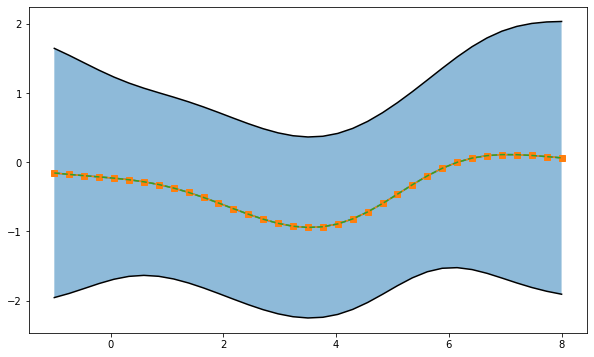

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(index_points[:, 0], f, 'o')
#ax.plot(index_points[:, 0], y, '+')
ax.plot(xnew[:, 0], post_gp.mean_function(xnew))
ax.plot(xnew[:, 0], tf_m[0], 's-')
#ax.plot(xnew[:, 0], cond_mean_fn(xnew))


ax.fill_between(xnew[:, 0], m + 2*sd, m - 2*sd, alpha=0.5)
ax.plot(xnew[:, 0], f_mean[:, 0], '--')
ax.plot(xnew[:, 0], f_mean[:, 0] + 2*onp.sqrt(f_var[:, 0]), 'k-')
ax.plot(xnew[:, 0], f_mean[:, 0] - 2*onp.sqrt(f_var[:, 0]), 'k-')



plt.show()

In [18]:
# conditional mean function is wrong!

In [20]:
gpflow_mod.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-16.097046218827224>

In [24]:
pf = gp.marginal()
py = distributions.MultivariateNormalFull(
    pf.mean, pf.scale @ pf.scale.T + jnp.eye(10)*obs_noise_scale**2)


In [25]:
py.log_prob(y)

DeviceArray(-16.097, dtype=float64)